# Generalized Additive Models (GAM)

*The following code tutorial is mainly based on the [statsmodels documentation](https://www.statsmodels.org/v0.10.0/gam.html) about generalized additive models (GAM). To learn more about this method, review ["An Introduction to Statistical Learning"](https://www.statlearning.com/) from {cite:t}`James2021`. GAMs were originally developed by Trevor Hastie and Robert Tibshirani (who are two coauthors of {cite:t}`James2021`) to blend properties of generalized linear models with additive models.*

- A generalized additive model (GAM) is a way to extend the multiple linear regression model {cite:p}`James2021`. 
- Remember that the basic regression model can be stated as:

$$y_i = \beta_0 + \beta_1 x_{i1} + \beta_2 x_{i2} + ... + \beta_P x_{iP} + \epsilon_i$$

- which equals

$$y_i = \beta_0 + \sum_{j=1}^{p} \beta x_{ij} + \epsilon_i$$



- In order to allow for non-linear relationships between each feature and the response we need to replace each linear component $\beta_j x_{ij}$ with a (smooth) nonlinear function $f_j (x_{ij})$. 

- We would then write the model as:

$$y_i = \beta_0 + \sum_{j=1}^{p} f(x_{ij}) + \epsilon_i$$

- This is an example of a GAM. It is called an *additive* model because we calculate a separate $f_j$ for each $X_j$, and then add together all of their contributions.

- In particular, generalized additive models allow us to use and combine regression splines, smoothing splines and local regression to deal with multiple predictors in one model. This means you can combine the different methods in your model and are able to decide which method to use for every feature. 

- Note that in most situations, the differences in the GAMs obtained using smoothing splines versus natural splines are small {cite:p}`James2021`).

- In [](splines.ipynb), we discussed regression splines, which we created by specifying a set of knots, producing a sequence of basis functions, and then using least squares to estimate the spline coefficients. 


- In this tutorial, we use a GAM with a reguralized estimation of [smooth components using B-Splines](https://www.statsmodels.org/stable/generated/statsmodels.gam.smooth_basis.BSplines.html#statsmodels.gam.smooth_basis.BSplines). 

- Note that we could also use additive smooth components using [cyclic cubic regression splines](https://www.statsmodels.org/stable/generated/statsmodels.gam.smooth_basis.CyclicCubicSplines.html#statsmodels.gam.smooth_basis.CyclicCubicSplines) (e.g. in time series data with seasonal effects).

## Setup

In [57]:
import numpy as np

from statsmodels.gam.api import BSplines
from statsmodels.gam.api import GLMGam
from statsmodels.tools.eval_measures import mse, rmse

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

## Data preparation

- See [](hitters_data.ipynb) for details about the data preprocessing steps.
- We simply import the preprocessed data by using this [Python script](https://github.com/kirenz/regression/blob/main/docs/hitters_data.py) which will yield:
  - X_train, X_test, y_train, y_test
  - df_train and df_tests

In [35]:
from hitters_data import *

In [36]:
df_train

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,...,CWalks,PutOuts,Assists,Errors,League_N,Division_W,NewLeague_N,Salary,y_pred,pred_train
260,0.644577,0.257439,-0.456963,0.101010,-0.763917,-0.975959,-0.070553,0.298535,0.239063,-0.407836,...,-0.361084,-0.482387,1.746229,3.022233,1,1,1,875.0,662.397284,662.397284
92,-0.592807,-0.671359,-0.572936,-0.778318,-0.685806,-0.458312,-1.306911,-1.001403,-0.969702,-0.746705,...,-0.844319,-0.851547,0.022276,2.574735,0,0,0,70.0,106.459608,106.459608
137,-0.413075,-0.105019,-0.688910,-0.258715,-0.646751,-0.081841,1.577925,0.717456,0.706633,-0.010542,...,0.220252,-0.294452,-0.434676,0.635577,0,0,0,430.0,756.439710,756.439710
90,-0.613545,-0.558091,0.122907,-0.618440,-0.256196,-1.211253,-0.482672,-0.514087,-0.478077,-0.501317,...,-0.684451,0.786178,-0.545452,-0.706917,0,1,0,431.5,232.771697,232.771697
100,0.637665,0.982354,0.586803,0.260888,1.227914,1.706394,0.547626,1.267183,1.437305,2.384908,...,1.615457,2.504446,-0.213124,0.635577,0,0,0,2460.0,1121.121890,1121.121890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274,0.824309,0.733164,0.470829,0.740521,0.954525,0.859335,-0.688732,-0.824858,-0.808834,-0.571428,...,-0.648118,3.427344,0.326910,1.232241,1,0,1,200.0,317.381231,317.381231
196,0.423369,0.461321,1.862516,0.500704,1.618469,0.482865,1.165805,1.354814,1.246368,1.625375,...,0.681687,-1.002566,-0.822392,-1.303581,0,1,0,587.5,936.983487,936.983487
159,1.474109,1.254197,1.746542,1.140215,2.126191,-0.458312,-0.894792,-0.522636,-0.520174,-0.068968,...,-0.662651,-0.633407,1.310048,0.933909,0,1,0,200.0,622.401072,622.401072
17,-1.470728,-1.396275,-1.152806,-1.217982,-1.740306,-1.258312,-0.482672,-0.932153,-0.933620,-0.770075,...,-0.818885,-0.660255,0.403069,1.083075,0,1,0,175.0,31.929032,31.929032


## Spline basis

- First we have to create a basis spline ("B-Spline"). 
- In this example, we only select two features: `CRuns` and `Hits`.

In [37]:
# choose features
x_spline = df_train[['CRuns', 'Hits']]

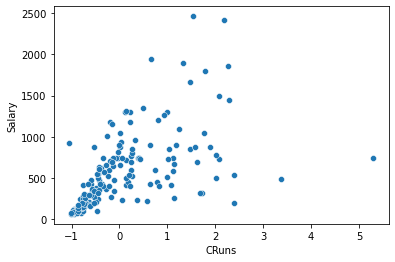

In [38]:
sns.scatterplot(x='CRuns', y='Salary', data=df_train);

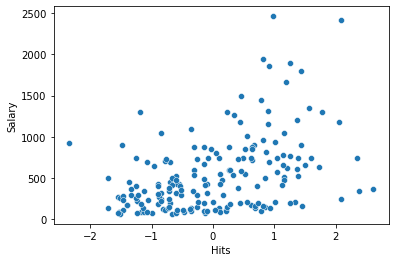

In [39]:
sns.scatterplot(x='Hits', y='Salary', data=df_train);

- Now we need to divide the range of X into K distinct regions (for every feature). 
- Within each region, a polynomial function is fit to the data. 

- In the statsmodels function `BSplines`, we need to provide `df` and `degree`:

  - `df`: number of basis functions or degrees of freedom; should be equal in length to the number of columns of x; may be an integer if x has one column or is 1-D.  

  - `degree`: degree(s) of the spline; the same length and type rules apply as to df.


### Degrees of freedom

- Instead of providing the number of knots, in statsmodels, we have to specify the degrees of freedom (df). 
- `df` defines how many parameters we have to estimate. 
- They have a specific relationship with the number of knots and the degree, which depends on the type of spline (see [Stackoverflow](https://stats.stackexchange.com/a/517479)):

- In the case of **B-splines**: 
  - $df=𝑘+degree$ if you specify the knots or 
  - $𝑘=df−degree$ if you specify the degrees of freedom and the degree. 


As an example: 

- A cubic spline (degree=3) with 4 knots (K=4) will have $df=4+3=7$ degrees of freedom. If we use an intercept, we need to add an additional degree of freedom.
- A cubic spline (degree=3) with 5 degrees of freedom (df=5) will have $𝑘=5−3=2$ knots (assuming the spline has no intercept).

:::{Note}
The higher the degrees of freedom, the "wigglier" the spline gets because the number of knots is increased {cite:p}`James2021`.
:::

## Model

- We want to fit a cubic spline (degree=3) with an intercept and three knots (K=3). 
- We use this values for both of our features (we also could use different values for one of the features). 
- This equals $df=3+3+1=7$ for both of the features. This means that these degrees of freedom are used up by an intercept, plus six basis functions.



In [40]:
# create basis spline
bs = BSplines(x_spline, df=[7, 7], degree=[3, 3])

In [41]:
# fit model
reg = GLMGam.from_formula('Salary ~ CRuns + Hits', 
                                data=df_train, 
                                smoother=bs).fit()

In [42]:
# print results
print(reg.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 Salary   No. Observations:                  184
Model:                         GLMGam   Df Residuals:                   171.00
Model Family:                Gaussian   Df Model:                        12.00
Link Function:               identity   Scale:                          90949.
Method:                         PIRLS   Log-Likelihood:                -1304.8
Date:                Sat, 23 Apr 2022   Deviance:                   1.5552e+07
Time:                        14:34:52   Pearson chi2:                 1.56e+07
No. Iterations:                     3   Pseudo R-squ. (CS):             0.7307
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    690.7415    160.681      4.299      0.0

## Plot

- The results classes provide a `plot_partial` method that plots the partial linear prediction of a smooth component. 
- The partial residual or component plus residual can be added as scatter point with `cpr=True`.

- Spline for feature `CRuns`:

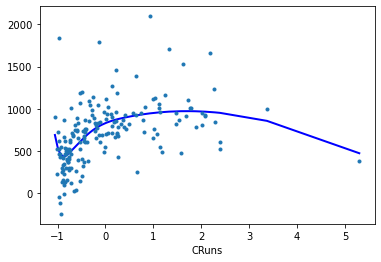

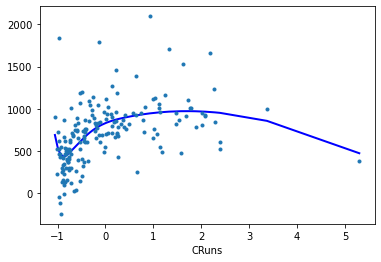

In [43]:
reg.plot_partial(0, cpr=True, plot_se=False)

- Spline for feature `Hits`:

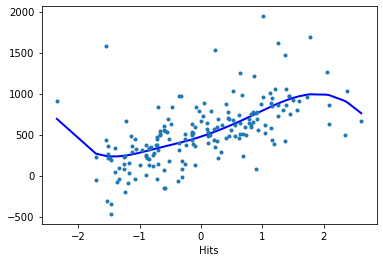

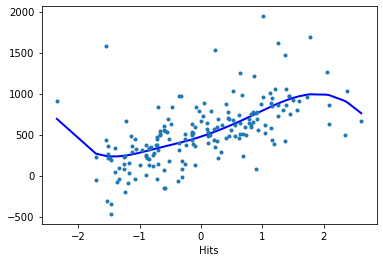

In [44]:
reg.plot_partial(1, cpr=True, plot_se=False)

## Model evaluation

### Training data

In [45]:
# Training data
df_train['pred_train'] = reg.predict()
rmse_train = round(rmse(df_train['Salary'], df_train['pred_train']),4)

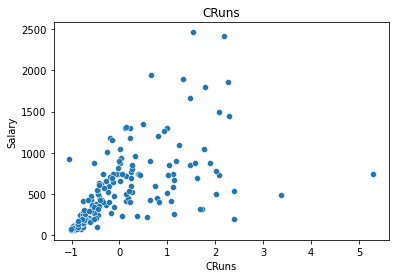

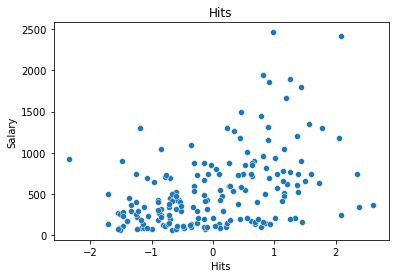

In [60]:
# plot training data
features = ['CRuns', 'Hits']

for i in features:
    g = sns.scatterplot(x=i, y='Salary', data=df_train)
    plt.title(i)
    plt.show();

### Test data

- We need to make sure that our test data falls inside the boundaries of the outermost knots (otherwise, we get an error)

In [46]:
# Obtain limits of training data features
x0_min = X_train['CRuns'].min()
x0_max = X_train['CRuns'].max()

x1_min = X_train['Hits'].min()
x1_max = X_train['Hits'].max()

In [47]:
# Only keep test data within training data limits
df_test = df_test[(df_test["CRuns"] > x0_min) & (df_test["CRuns"] < x0_max)]
df_test = df_test[(df_test["Hits"] > x1_min) & (df_test["Hits"] < x1_max)]

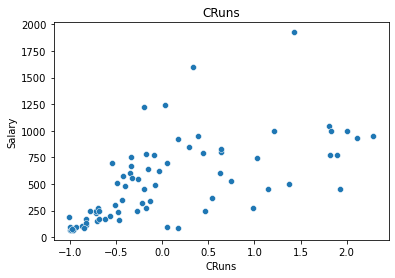

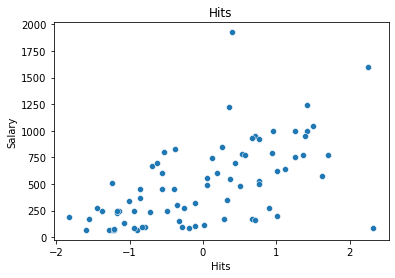

In [61]:
# plot test data
for i in features:
    g = sns.scatterplot(x=i, y='Salary', data=df_test)
    plt.title(i)
    plt.show();

In [48]:
# Obtain test RMSE
df_test['pred_test'] = reg.predict(df_test, exog_smooth= df_test[['CRuns', 'Hits']])
rmse_test = round(rmse(df_test['Salary'], df_test['pred_test']),4)

In [49]:
# Save model results
results = {"model": "GAM", "rmse_train": rmse_train, "rmse_test": rmse_test}

results

{'model': 'GAM', 'rmse_train': 290.7294, 'rmse_test': 272.6471}